In [184]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from Baysian_Mat import Bayesian_Matte
from PIL import Image, ImageOps
import time  # Execution TIme imports
import psutil

from laplac import Laplacianmatting
from compositing import compositing
from QualityTest import mse2d
from QualityTest import sad2d
from QualityTest import psnr2d
from smooth import smooth

In [217]:
# get current memory usage
Memstart = psutil.Process().memory_info().rss / (1024**2)


# Step 1 : Read image, GT and trimap.
image = np.array(Image.open("C:/Users/aduttagu/Desktop/Bayesian-Matting-Implementation/input_lowres/troll.png"))
image_trimap = np.array(ImageOps.grayscale(Image.open("C:/Users/aduttagu/Desktop/Bayesian-Matting-Implementation/trimap_lowres/Trimap1/troll.png")))
#GT = np.array(ImageOps.grayscale(Image.open("C:/Users/aduttagu/Desktop/Bayesian-Matting-Implementation/gt_training_lowres/GT01.png")))

# Start time for computing the execution time
st = time.time()

# Step 2 : Calculating Bayesian Matte for the given trimap
alpha,pixel_count = Bayesian_Matte(image,image_trimap) 

# Step 3 : Making it back to range (0-255) for display purpose
alpha_disp = alpha * 255
alpha_int8 = np.array(alpha,dtype = int)

et = time.time()
elapsed_time = et - st


Successfully Calculated : 1000.0 out of unknown Pixels : 231995.
Successfully Calculated : 2000.0 out of unknown Pixels : 231995.
Successfully Calculated : 3000.0 out of unknown Pixels : 231995.
Successfully Calculated : 4000.0 out of unknown Pixels : 231995.
Successfully Calculated : 5000.0 out of unknown Pixels : 231995.
Successfully Calculated : 6000.0 out of unknown Pixels : 231995.
Successfully Calculated : 7000.0 out of unknown Pixels : 231995.
Successfully Calculated : 8000.0 out of unknown Pixels : 231995.
Successfully Calculated : 9000.0 out of unknown Pixels : 231995.
Successfully Calculated : 10000.0 out of unknown Pixels : 231995.
Successfully Calculated : 11000.0 out of unknown Pixels : 231995.
Successfully Calculated : 12000.0 out of unknown Pixels : 231995.
Successfully Calculated : 13000.0 out of unknown Pixels : 231995.
Successfully Calculated : 14000.0 out of unknown Pixels : 231995.
Successfully Calculated : 15000.0 out of unknown Pixels : 231995.
Successfully Calcul

Text(0.5, 1.0, 'Alpha - Bayesian')

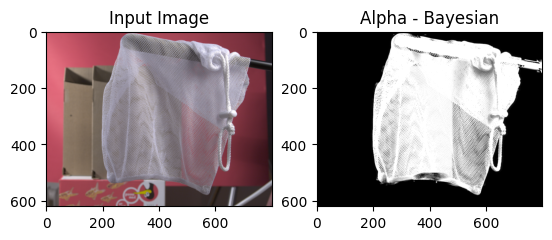

In [219]:
# Step 7 : Displaying THe Bayesian, and smooth.
fig, axes = plt.subplots(nrows = 1, ncols = 2)
axes[0].imshow(image)
axes[0].set_title('Input Image')
axes[1].imshow(alpha_disp, cmap = 'gray')
axes[1].set_title('Alpha - Bayesian')

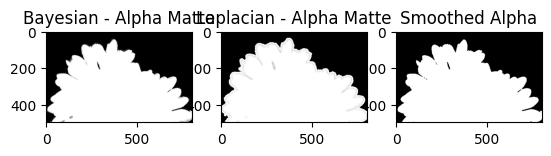

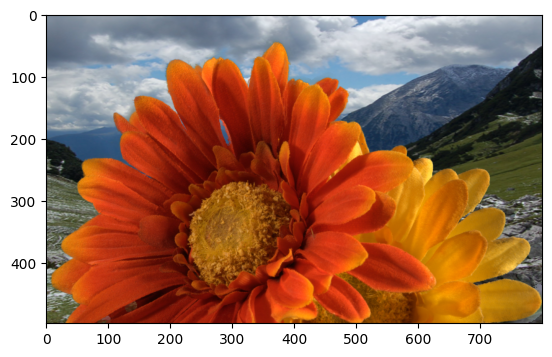

Execution time for Bayesian Matting: 42.125 seconds
Total memory consumed in execution of this program :  27.28125 MB's


In [212]:
# Step 4 : End to End testing - 1 : Calculating the Laplacian Matting
Lalpha = Laplacianmatting(image, image_trimap)

# Step 5 : Compositing Function Display
background = np.array(Image.open('C:/Users/aduttagu/Desktop/Bayesian-Matting-Implementation/background.png'))
comp_Bay = compositing(image, alpha_disp, background)

# Step 6 : Smoothening ALpha Methods
smooth_alpha = smooth(alpha_disp)

# Step 7 : Displaying THe Bayesian, Laplacian and GT.
fig, axes = plt.subplots(nrows = 1, ncols = 3)
axes[0].imshow(alpha_disp, cmap='gray')
axes[0].set_title('Bayesian - Alpha Matte')
axes[1].imshow(Lalpha, cmap='gray')
axes[1].set_title('Laplacian - Alpha Matte')
axes[2].imshow(smooth_alpha, cmap='gray')
axes[2].set_title('Smoothed Alpha')
plt.show()



plt.imshow(comp_Bay)
plt.show()


# # Part of End to End testing - 1 : Performance Comparision between Laplacian and Bayesian. 
# Bay_MSE = mse2d(alpha_disp, GT)
# Lap_MSE = mse2d(Lalpha, GT)
# print("The MSE between the Ground Truth and Bayesian Alpha Matte is :", Bay_MSE)
# print("The MSE between the Ground Truth and Laplacian Alpha Matte is :", Lap_MSE)

# Bay_SAD = sad2d(alpha_disp, GT)
# Lap_SAD = sad2d(Lalpha, GT)
# print("The SAD between the Ground Truth and Bayesian Alpha Matte is :", Bay_SAD)
# print("The SAD between the Ground Truth and Laplacian Alpha Matte is :", Lap_SAD)

# Bay_PSNR = psnr2d(alpha_disp, GT)
# Lap_PSNR = psnr2d(Lalpha, GT)
# print("The PSNR between the Ground Truth and Bayesian Alpha Matte is :", Bay_PSNR)
# print("The PSNR between the Ground Truth and Laplacian Alpha Matte is :", Lap_PSNR)


print('Execution time for Bayesian Matting: {:.3f} seconds'.format(elapsed_time))

# get usage after completion of code
Memend = psutil.Process().memory_info().rss / (1024**2)
Memuse = Memend - Memstart
print("Total memory consumed in execution of this program : ", Memuse, "MB's")

Text(0.5, 1.0, 'Composite')

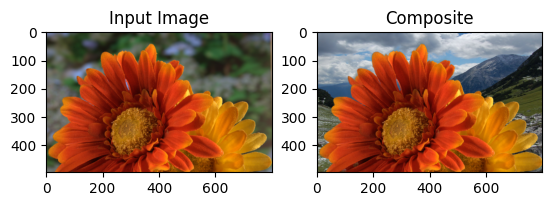

In [213]:
# Step 7 : Displaying THe Bayesian, and smooth.
fig, axes = plt.subplots(nrows = 1, ncols = 2)
axes[0].imshow(image)
axes[0].set_title('Input Image')
axes[1].imshow(comp_Bay)
axes[1].set_title('Composite')

Text(0.5, 1.0, 'Smooth - Alpha Matte')

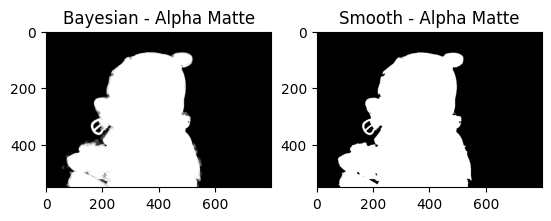

In [209]:
# Step 7 : Displaying THe Bayesian, and smooth.
fig, axes = plt.subplots(nrows = 1, ncols = 2)
axes[0].imshow(alpha_disp, cmap='gray')
axes[0].set_title('Bayesian - Alpha Matte')
axes[1].imshow(smooth_alpha, cmap='gray')
axes[1].set_title('Smooth - Alpha Matte')


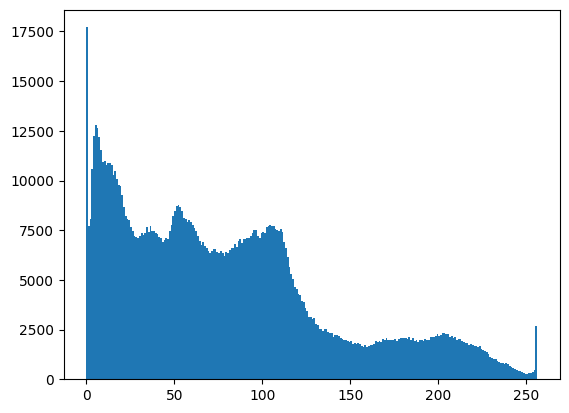

In [164]:
  
# calculate histogram only using Y channel 
hist_in = cv2.calcHist([image],[0],None,[256],[0,256])


plt.hist(image.ravel(), 256, [0,256])
plt.show()


# plt.figure(1)    
# plt.subplot(1, 2, 1)
# plt.plot(hist_in, color='b')
# plt.title('Histogram of input image ')

# plt.figure(1)    
# plt.subplot(1, 2, 2)
# plt.plot(hist_co, color='b')
# plt.title('Histogram of composited Image')
# plt.show()
    

In [168]:
print(image.dtype)
print(comp_Bay.dtype)
Ncomp_Bay = (comp_Bay * 255).astype(np.uint8)
print(Ncomp_Bay.dtype)

uint8
float64
uint8


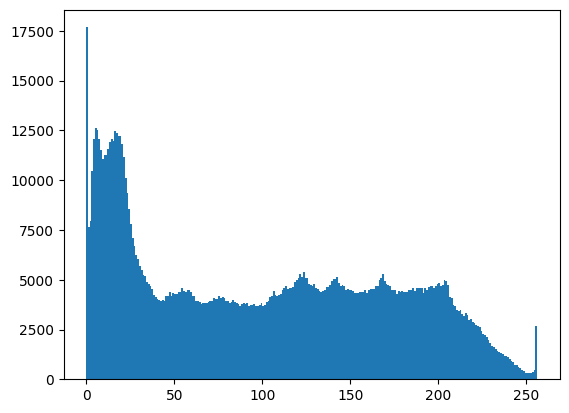

In [169]:
hist_co = cv2.calcHist([Ncomp_Bay],[0],None,[256],[0,256]) 
plt.hist(Ncomp_Bay.ravel(), 256, [0,256])
plt.show()



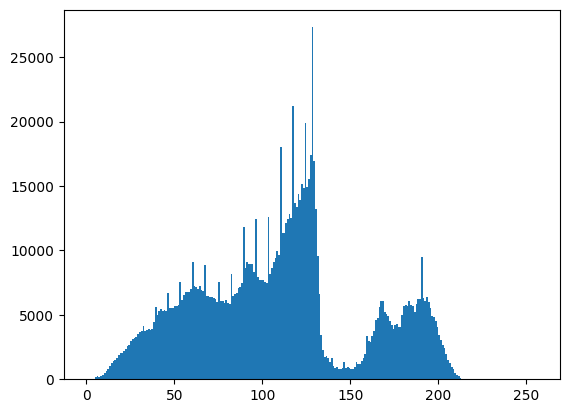

In [171]:

img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
hist_co = cv2.calcHist([img_yuv],[0],None,[256],[0,256]) 
plt.hist(img_yuv.ravel(), 256, [0,256])
plt.show()



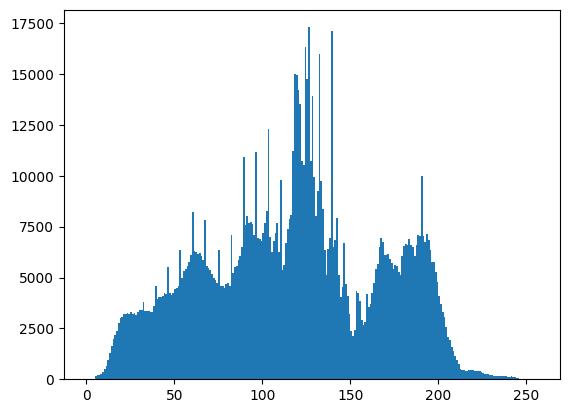

In [173]:
img_yuv2 = cv2.cvtColor(Ncomp_Bay, cv2.COLOR_BGR2YUV)
hist_co = cv2.calcHist([Ncomp_Bay],[0],None,[256],[0,256]) 
plt.hist(img_yuv2.ravel(), 256, [0,256])
plt.show()


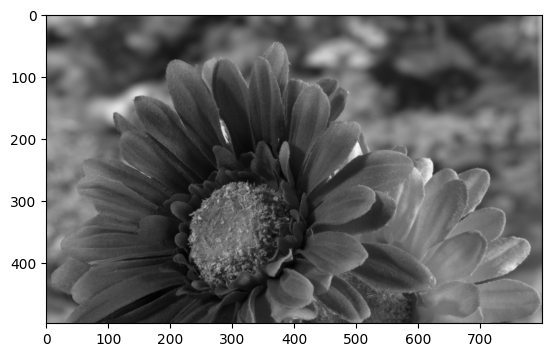

In [181]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap="gray")
plt.show()

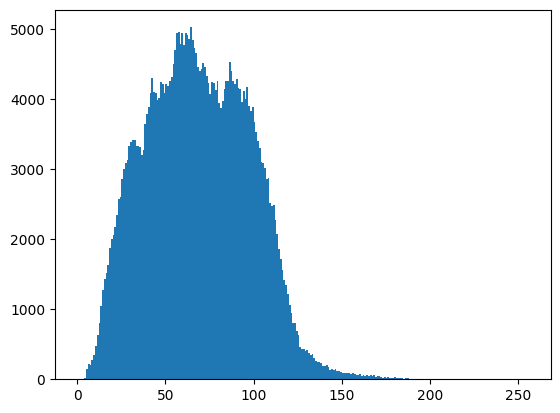

In [182]:
hist_co = cv2.calcHist([gray_image],[0],None,[256],[0,256]) 
plt.hist(gray_image.ravel(), 256, [0,256])
plt.show()


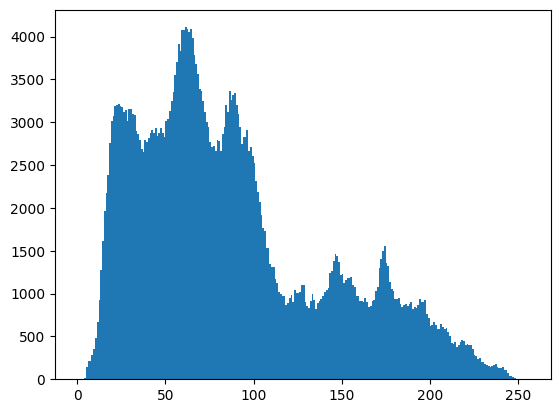

In [183]:
gray_image2 = cv2.cvtColor(Ncomp_Bay, cv2.COLOR_BGR2GRAY)
hist_co = cv2.calcHist([gray_image2],[0],None,[256],[0,256]) 
plt.hist(gray_image2.ravel(), 256, [0,256])
plt.show()


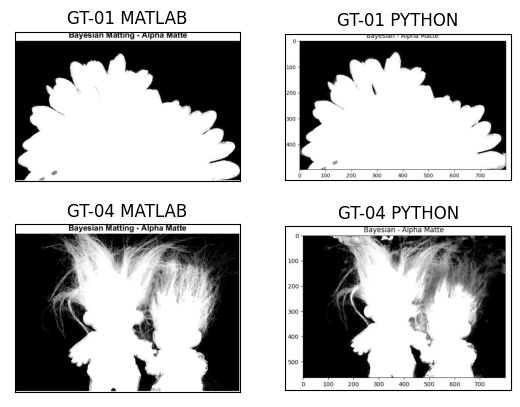

In [193]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the four images
gt_01_matlab = mpimg.imread('C:/Users/aduttagu/Desktop/Main/GT01_MATvsPY.png')
gt_01_python = mpimg.imread('C:/Users/aduttagu/Desktop/Main/GT01_PYvsMAT.jpg')
gt_04_matlab = mpimg.imread('C:/Users/aduttagu/Desktop/Main/GT04_MATvsPY.png')
gt_04_python = mpimg.imread('C:/Users/aduttagu/Desktop/Main/GT04_PYvsMAT.jpg')

# Create a figure and subplots
fig, axs = plt.subplots(2, 2)

# Set the titles for each subplot
axs[0, 0].set_title('GT-01 MATLAB')
axs[0, 1].set_title('GT-01 PYTHON')
axs[1, 0].set_title('GT-04 MATLAB')
axs[1, 1].set_title('GT-04 PYTHON')

# Plot each image in its corresponding subplot
axs[0, 0].imshow(gt_01_matlab)
axs[0, 1].imshow(gt_01_python)
axs[1, 0].imshow(gt_04_matlab)
axs[1, 1].imshow(gt_04_python)

# Hide the tick labels for each subplot
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

# Display the figure
plt.show()


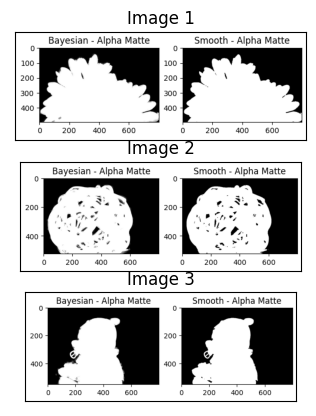

In [210]:
# Load the three images
img1 = mpimg.imread('C:/Users/aduttagu/Desktop/Main/smooth1.png')
img2 = mpimg.imread('C:/Users/aduttagu/Desktop/Main/smooth2.png')
img3 = mpimg.imread('C:/Users/aduttagu/Desktop/Main/smooth3.png')


# Create a figure and subplots
fig, axs = plt.subplots(3, 1)

# Set the titles for each subplot
axs[0].set_title('Image 1')
axs[1].set_title('Image 2')
axs[2].set_title('Image 3')

# Plot each image in its corresponding subplot
axs[0].imshow(img1)
axs[1].imshow(img2)
axs[2].imshow(img3)

# Hide the tick labels for each subplot
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

# Display the figure
plt.show()

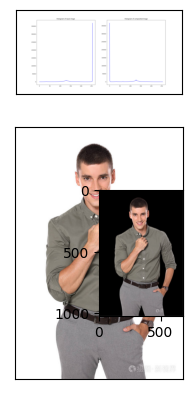

In [216]:
# Load the three images
img1 = mpimg.imread('C:/Users/aduttagu/Desktop/Main/Figure_1.png')
img2 = mpimg.imread('C:/Users/aduttagu/Desktop/Main/IMG_9091.jpg')
img3 = mpimg.imread('C:/Users/aduttagu/Desktop/Main/IMG_9093.jpg')

# Create a figure and subplots
fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]})

# Set the titles for each subplot
axs[0].imshow(img1)

# Plot the second image in the top right subplot
axs[1].imshow(img2)

# Create an inset axes object for the third image
axins = axs[1].inset_axes([0.5, 0, 0.5, 1], transform=axs[1].transAxes)
axins.imshow(img3)

# Hide the tick labels for each subplot
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

# Display the figure
plt.show()